In [1]:
import os
import rsnapsim as rss
import pkg_resources
pkg_resources.require("numpy>=`1.20.1")  #  to use specific numpy version
import numpy as np
print('numpy version =', np.version.version)
print('rsnapsim version =',rss.__version__)
from sys import platform
import os
from skimage import io ; from skimage.io import imread; from skimage.measure import find_contours
from random import randrange
import os; from os import listdir; from os.path import isfile, join
import pandas as pd
import os; from os import listdir; from os.path import isfile, join
import re
import shutil
from random import randrange
# Parallel computing
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
from timeit import default_timer as timer

# Importing rSNAPsim_IP
cwd = os.getcwd(); os.chdir('../../rsnaped'); import rsnaped as rsp ; os.chdir(cwd) # return to the working directory
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout ; from IPython.display import Image

numpy version = 1.20.1
rsnapsim version = 0.0.18


In [2]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.size'] = 15
plt.rcParams['axes.grid'] = False

In [3]:
number_trajectories = 1000
simulation_time_in_sec = 1000
step_size_in_sec =1

# Running SSA

In [4]:
gene_file_h2b = '../../DataBases/gene_files/H2B_withTags.txt'
gene_file_bact = '../../DataBases/gene_files/Bactin_withTags.txt'

## Running the SSA in serial

In [5]:
#t = np.linspace(0,simulation_time_in_sec,simulation_time_in_sec+1)

In [6]:
def rsnapsim_ssa(gene_file,ke =3,ki=0.033,frames=100,n_traj=20):
    poi_strs, poi_objs, tagged_pois,raw_seq = rss.seqmanip.open_seq_file(gene_file)
    gene_obj = tagged_pois['1'][0]
    gene_obj.ke = ke
    rss.solver.protein = gene_obj #pass the protein object
    t_burnin = 10000
    t = np.linspace(0,t_burnin+frames,t_burnin+frames+1)
    ssa_solution = rss.solver.solve_ssa(gene_obj.kelong, t, ki=ki, kt = ke, low_memory=False,record_stats=False,n_traj=n_traj)
    #time = ssa_solution.time[t_burnin:-1]
    #time= time-t_burnin
    ssa_int =  ssa_solution.intensity_vec[0,t_burnin:-1,:].T
    return ssa_int

In [7]:
start = timer()
ssa_solution_b_act = rsnapsim_ssa(gene_file_bact,frames=simulation_time_in_sec,n_traj=number_trajectories)
end = timer()
print('Time for serial ssa',round(end - start), ' sec')

Time for serial ssa 48  sec


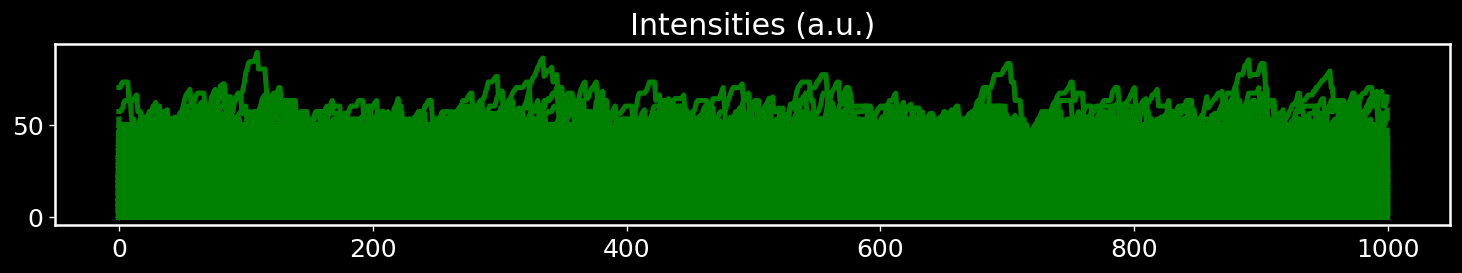

In [8]:
plt.figure(figsize=(15,2))
for tr in range(0,ssa_solution_b_act.shape[0] ):
    plt.plot(ssa_solution_b_act[tr,:] , '-',linewidth = 3,color='green');
plt.title('Intensities (a.u.)')
plt.show()

## Running the SSA in parallel

In [9]:
def rsnapsim_ssa_parallel(gene_file,ke =3,ki=0.033,frames=100,n_traj=1):
    poi_strs, poi_objs, tagged_pois,raw_seq = rss.seqmanip.open_seq_file(gene_file)
    gene_obj = tagged_pois['1'][0]
    gene_obj.ke = ke
    rss.solver.protein = gene_obj #pass the protein object
    t_burnin = 10000
    t = np.linspace(0,t_burnin+frames,t_burnin+frames+1)
    ssa_solution = rss.solver.solve_ssa(gene_obj.kelong, t, ki=ki, kt = ke, low_memory=False,record_stats=False,n_traj=n_traj)
    #time = ssa_solution.time[t_burnin:-1]
    #time= time-t_burnin
    ssa_int =  ssa_solution.intensity_vec[0,t_burnin:-1,:].T
    return ssa_int

In [10]:
start = timer()
list_ssa = Parallel(n_jobs=num_cores)(delayed(rsnapsim_ssa_parallel)(gene_file_bact,frames=simulation_time_in_sec) for i in range(0,number_trajectories)) 
ssa_solution_b_act_parallel = np.concatenate( list_ssa, axis=0 )
end = timer()
print('Time for parallel ssa',round(end - start), ' sec')

Time for parallel ssa 6  sec


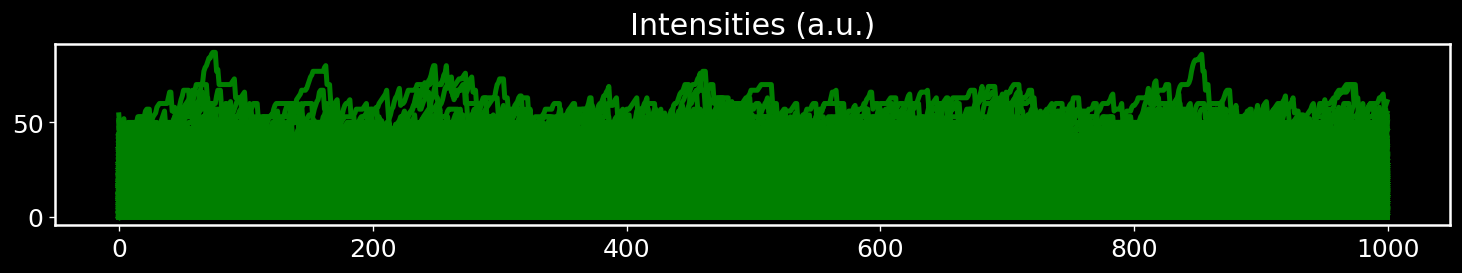

In [11]:
plt.figure(figsize=(15,2))
for tr in range(0,ssa_solution_b_act.shape[0] ):
    plt.plot(ssa_solution_b_act_parallel[tr,:] , '-',linewidth = 3,color='green');
plt.title('Intensities (a.u.)')
plt.show()